# Comparison of Different Convergence Algorithms for the L-21 Regularizer and the 2-norm matrix objective

In [1]:
import numpy as np 
from scipy.sparse import random as sprandn
import matplotlib.pyplot as plt

Initializing some basic compute constants. We assume in this case that **"w" is uniform** and but it needn't be. In the library implementations of this algorithm, the code to extract "w" is provided. Although this is not relevant for this comparison. Indeed, the proximal operators still work with w as mentioned in the paper. Further, the gain matrix **A** is aritificially modelled and the matrix X is artificially constructed and verified. 

Also noise is added artificially. In this simulation we also make the simplification that the **gain matrix G is square**. This implies that the number of sensors is equal to the number of sources. This is generally not the case, but the example has visual similarity to the source, so it is interesting to consider.

Text(0.5,1,'Clean Artificial Plot of Brain Source Activity')

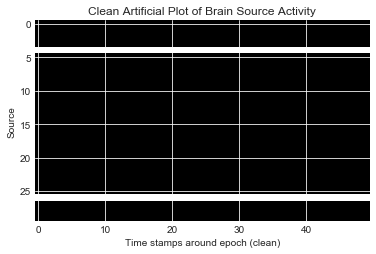

In [39]:
m = 30 	#number of sources
k = 10 # number of sensors
m_ = float(m)
n = 50 # number of time stamps around each epoch
A_ = np.matrix(np.random.randn(k,m)) # defining a random A
A_ = (A_-np.mean(A_,0))/np.std(A_,0) # normalize columns at each time instant.
X_r = [np.random.uniform(0,1,m) < 3.0/m]
X = np.tile(X_r, (n,1))
X = X.T
X = X.astype(int)
plt.imshow(X, cmap = "gray")
plt.xlabel("Time stamps around epoch (clean)")
plt.ylabel("Source")
plt.title("Clean Artificial Plot of Brain Source Activity")

The code below generates the noisy signal to model the sensor output in non-invasive processes. The goal would be to recreate the above image using the understanding of sparsity and its structure in this context.

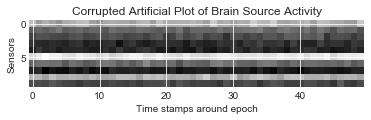

In [64]:
B = A_*X + np.sqrt(0.1)*np.matrix(np.random.randn(k,n)) # creating the O/P
plt.imshow(B, cmap = "gray")
plt.xlabel("Time stamps around epoch")
plt.ylabel("Sensors")
plt.title("Corrupted Artificial Plot of Brain Source Activity")
# cached computations: these don't need to be repeatedly computed for comparison

maxit = 100
V = 1e-4
W = 1e-2 #error tolerance for ADMM

Now we create some special functions to vectorize the matrices to vectors that are easier to work with.

In [65]:
b = B.T.reshape(k*n,1)
A = np.kron(np.eye(n), A_)
ATA = A.T*A
ATb = A.T*b

## The construction of various models and their hyperparameters
The parameters are obtained from literature and/or commonsense. The parameters are kept constant across models when possible. Also we implement the proximal operator from scratch. Note that this can in fact be vectorized so our implementation from the previous section can be used. The L21 norm requires careful 2-norm along space and 1-norm across time.

In [66]:
def switch(x):
    X = x.reshape(n,m).T
    return X

def l21(x):
    X = switch(x)
    sumo = 0.0
    for i in range(m):
        sumt = 0.0
        for j in range(n):
            sumt = sumt + X[i,j]*X[i,j]
        sumo = sumo + np.sqrt(sumt)
    return sumo

def objective(A,x,b,gamma):
    return f(A,x,b) + gamma*l21(x)

def f(A,x,b):
    return 0.5*(np.linalg.norm(A*x-b)**2)

def gradf(ATA,x,ATb):
    return ATA*x-ATb 

def uppbd(A,ATA,ATb,x,x_1,b,lK):
    xd = x_1 - x
    return f(A,x,b) + 1.0/(2.0*lK)* np.sum(np.multiply(xd,xd)) + gradf(ATA,x,ATb).T*xd 
    
# def proxop(zeta,lamdaK):
#     f = np.matrix(np.zeros(np.shape(zeta)))
#     return np.multiply(np.sign(zeta),np.maximum(np.abs(zeta)-lamdaK,f))
def proxop(zeta,lamdaK):
    Z = switch(zeta)
    q = np.matrix(np.zeros((np.shape(zeta)[0],1)))
    for i in range(0,len(zeta)):
        d = i/n
        q[i,0] = zeta[i,0]*np.maximum(0,1 - lamdaK/np.linalg.norm(Z[d,:]))
    return q


def proxf(ATA,zeta,ATb,W,n):
    return np.linalg.inv(W*np.identity(n*m)+ATA)*(ATb + 0.01*zeta)

### Defining the Convergence Algorithms for comparison

In [67]:
def PGD(maxit,lK,g,AtA,Atb,A,beta,b,V):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    obj = []
    for k in range(maxit):
        while True:
            xr = proxop(x-lK*gradf(AtA,x,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,x,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        x = xr
    return obj,xr

def APGD(maxit,lK,g,AtA,Atb,A,beta,b,V):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    xp = x
    obj = []
    for k in range(maxit):
        y = x + 1.0/(k+3)*(x-xp)
        while True:
            xr = proxop(y-lK*gradf(AtA,y,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,y,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        xp = x
        x = xr
    return obj,xr

def ADMM(maxit,lK,g,ATA,ATb,A,b,V,W,n):
    ldr = 1/lK
    x = np.matrix(np.random.randn(m*n,1))
    z = np.matrix(np.random.randn(m*n,1))
    t = np.matrix(np.random.randn(m*n,1))
    obj = []
    for k in range(maxit):
        xr = proxf(ATA,(z-t),ATb,W,n)
        zr = proxop(xr+t,(lK*g)/W) 
        tr = t + W*(xr - zr)
        ls = f(A,xr,b)+ g*np.sum(np.abs(zr))
        obj.append(ls)
        lsold = f(A,x,b)+ g*np.sum(np.abs(z))
        if k > 1 and np.linalg.norm(ls - lsold) < V:
            break
        z = zr
        x = xr
        t = tr        
    return obj, xr

### Running the Defined Solvers

In [68]:
lK = 1.0
be = 0.5
g =  0.01

obj1,d1 = PGD(maxit,lK,g,ATA,ATb,A,be,b,V)
obj2,d2 = APGD(maxit,lK,g,ATA,ATb,A,be,b,V)
obj3,d3 = ADMM(maxit,lK,g,ATA,ATb,A,b,V,W,n)

### Plotting the Convergence Graphs per method
Note: In this example, just for fun, we create a very agressive acceleration to observe the oscillation before convergence of the algorithm.

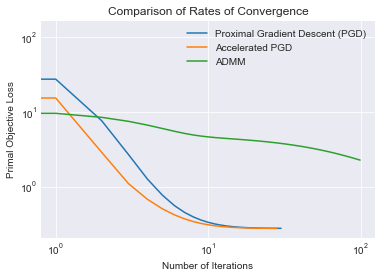

In [45]:
plt.style.use('seaborn-darkgrid')
plt.plot(range(len(obj1)), obj1,range(len(obj2)), obj2,range(len(obj3)), obj3)
plt.yscale('log')
plt.xscale('log')
plt.title('Comparison of Rates of Convergence')
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')
plt.legend(['Proximal Gradient Descent (PGD)', 'Accelerated PGD','ADMM'])

Text(0,0.5,'Primal Objective Loss')

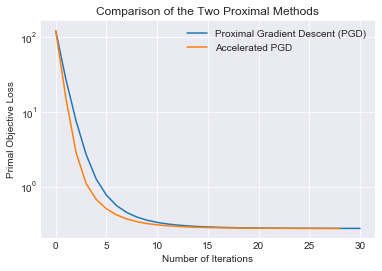

In [46]:
plt.plot(range(len(obj1)), obj1 ,range(len(obj2)), obj2)
plt.legend(['Proximal Gradient Descent (PGD)', 'Accelerated PGD'])
plt.yscale('log')
plt.title('Comparison of the Two Proximal Methods')
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')

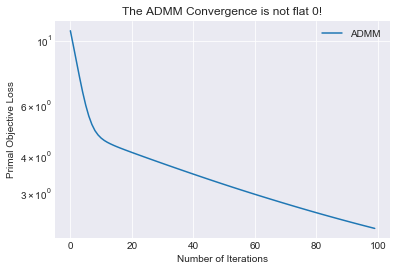

In [47]:
plt.plot(range(len(obj3)), obj3)
plt.title('The ADMM Convergence is not flat 0!')
plt.yscale('log')
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')
plt.legend(['ADMM'])

### Verifying the performance of these convergence methods with a soft thresholding to emphasize solutions

Text(0.5,1,'Reconstructed Source Signal')

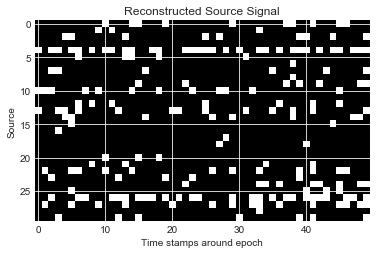

In [74]:
X_res = switch(d3)
hyperparam = 0.0
plt.imshow(X_res > 0.40   , cmap = "gray")
plt.xlabel("Time stamps around epoch")
plt.ylabel("Source")
plt.title("Reconstructed Source Signal")